## Preprocessing

In [0]:
# First the Usual Suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
# Then the network related packeges. NetworkX is the net package already in the repository, while nxviz is a visualization package that must be installed.
!pip -q install nxviz 
import networkx as nx
import nxviz as nv

In [0]:
!wget -q https://github.com/SDS-AAU/M2-2019/raw/master/notebooks/assignments/assignment_1/data/Krack-High-Tec-Attributes.csv -O atts
!wget -q https://github.com/SDS-AAU/M2-2019/raw/master/notebooks/assignments/assignment_1/data/Krack-High-Tec-edgelist-Advice.txt -O advice
!wget -q https://github.com/SDS-AAU/M2-2019/raw/master/notebooks/assignments/assignment_1/data/Krack-High-Tec-edgelist-Friendship.txt -O friends
!wget -q https://github.com/SDS-AAU/M2-2019/raw/master/notebooks/assignments/assignment_1/data/Krack-High-Tec-edgelist-ReportsTo.txt -O reports

Data is read and processed. At the end four dataframes will hold the data from the four given files.

In [0]:
df = pd.read_csv('atts')
df.set_index('ID', inplace=True)
dfa = pd.read_csv('advice', sep=" ", header=None)
dff = pd.read_csv('friends', sep=" ", header=None)
dfr = pd.read_csv('reports', sep=" ", header=None)

# During data importation, an empty column is created. This is then removed wit the .dropna function
dfa = dfa.dropna(axis=1)
dff = dff.dropna(axis=1)
dfr = dfr.dropna(axis=1)

# Columns are renamed
dfa.columns = ['ego', 'alter', 'a']
dff.columns = ['ego', 'alter', 'f']
dfr.columns = ['ego', 'alter', 'r']

# Non-edges are removed
dfa = dfa[dfa.a==1]
dff = dff[dff.f==1]
dfr = dfr[dfr.r==1]

## **Opgave** 1: Network Creation

In [0]:
# Network 'net' defines as bidirectional network
net = nx.DiGraph()

# Dictionary with node properties created from 'df'. Values are rounded for later (assortativity analysis works best with integers)
df = df.round().astype(int)
dfd = df.T.to_dict()

# Add edges from data to network
net.add_edges_from(zip(dfa.ego, dfa.alter), a=1)
net.add_edges_from(zip(dff.ego, dff.alter), f=1)
net.add_edges_from(zip(dfr.ego, dfr.alter), r=1)

# Dictionary added as node attributes
nx.set_node_attributes(net, dfd)

# Make edgelists for future reference
alist = list(zip(dfa.ego, dfa.alter))
flist = list(zip(dff.ego, dff.alter))
rlist = list(zip(dfr.ego, dfr.alter))

# Sub-networks created for future reference
neta = net.edge_subgraph(alist)
netf = net.edge_subgraph(flist)
netr = net.edge_subgraph(rlist)

Network Created. Let's make som plots of the network and sub-nets.

First the full network:

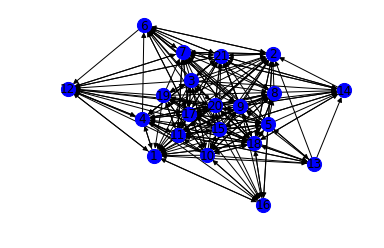

In [73]:
# Network created, let's make some plots
nx.draw_networkx(net,node_size=200, node_color='blue')
plt.axis('off') # We don't need axis
plt.show()

Advice relations

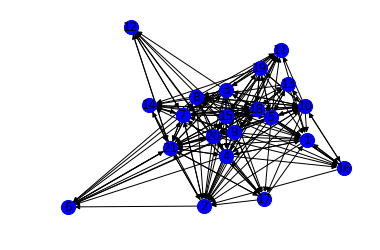

In [74]:
nx.draw_networkx(neta,node_size=200, node_color='blue')
plt.axis('off') # We don't need axis
plt.show()

Friendship relations

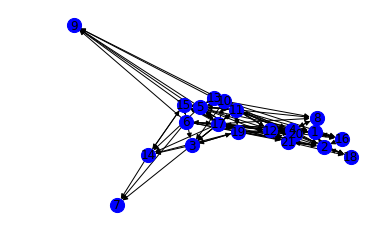

In [75]:
nx.draw_networkx(netf,node_size=200, node_color='blue')
plt.axis('off') # We don't need axis
plt.show()

Report relations

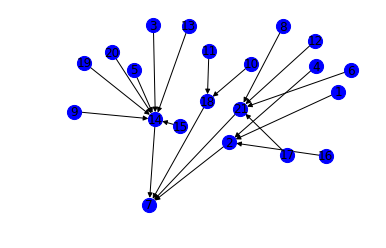

In [76]:
nx.draw_networkx(netr,node_size=200, node_color='blue')
plt.axis('off') # We don't need axis
plt.show()

## **Opgave** 2: Network analysis

Opgave 2a

In [77]:
Overview = pd.DataFrame(columns=list(['Network','Density','Transitivity','Reciprocity']))
Overview.Network = ['All', 'Advice', 'Friendship', 'Reports to']
Overview.Density = [nx.density(net), nx.density(neta), nx.density(netf), nx.density(netr)]
Overview.Transitivity = [nx.transitivity(net), nx.transitivity(neta), nx.transitivity(netf), nx.transitivity(netr)]
Overview.Reciprocity = [nx.reciprocity(net), nx.reciprocity(neta), nx.reciprocity(netf), nx.reciprocity(netr)]
Overview.set_index('Network', inplace=True)
Overview.head()

,Density,Transitivity,Reciprocity
Network,,,
All,0.552381,0.560993,0.629310
Advice,0.452381,0.465160,0.473684
Friendship,0.242857,0.275819,0.450980
Reports to,0.047619,0.000000,0.000000


**"Are relationships like friendship and advice giving usually reciprocal?"**

Friend and advice have a less than 0.5 reciprocity, meaning that less than half the advice and freindship relations are bidirectional. In laymans terms: "Only half of the people you call friends will count you as a friend; and only half the people you go to for advice, will come to you for advice."

This is measured by the transitivity in the friendship network. The answer is 27,58% of the time are friends of your friends also your friends.

**"Are the employees generally more likely to be in a friendship or advice-seeking relationship?"**

The advice network has a density of 0.45, while the friendship network has a density of 0.24. Therefore, employees are more likely to be in a advice relationship than a friendship.

## **Opgave 2**.b

**Who is most popular in the networks. Who is the most wanted friend, and advice giver?**

In [78]:
# Most popular advice
popular_advice = dfa.alter.value_counts().index.tolist()
print('The most popular advice giver has ID: {}'.format(popular_advice[0]))

# Modt popular friend
popular_friend = dff.alter.value_counts().index.tolist()
print('The most popular friend has ID: {}'.format(popular_friend[0]))

# ID is the same, let's have a look
print('Lets extract the data for this popular person')
df.loc[[popular_advice[0]]].head()

The most popular advice giver has ID: 2
The most popular friend has ID: 2
Lets extract the data for this popular person


,AGE,TENURE,LEVEL,DEPT
ID,,,,
2,42,20,2,4


**"Are managers in higher hirarchy more popular as friend, and advice giver?""**

This is tested by reconstructing the datasets and generating a table

In [79]:
# Let's add the previous advice and popularity columns to df
df['Advice'] = 0
df['Popularity']  = 0

# Let's populate those columns with the occurences of ID in in advice and friends dataframes respectively
tick = 0
while tick < len(df):
  tick +=1
  df.at[tick, "Advice"] = len(dfa[dfa.alter == tick])
  df.at[tick, "Popularity"] = len(dff[dff.alter == tick])
  
# Dataframe is now populated
df.head(21)

,AGE,TENURE,LEVEL,DEPT,Advice,Popularity
ID,,,,,,
1,33,9,3,4,13,8
2,42,20,2,4,18,10
3,40,13,3,2,5,5
4,33,8,3,4,8,5
5,32,3,3,2,5,6
6,59,28,3,1,10,2
7,55,30,1,0,13,3
8,34,11,3,1,10,5
9,62,5,3,2,4,6


In [80]:
# Lets get the means for advice and popularity (even if the CEO only have a single entry, and therefore the mean is redundant)
Hierarchy = pd.DataFrame(columns=list(['Rank','Advice','Friends']))
Hierarchy.Rank = ['CEO', 'Vice President', 'Manager']
Hierarchy.Advice = [df[df.LEVEL == 1].Advice.mean(), df[df.LEVEL == 2].Advice.mean(), df[df.LEVEL == 3].Advice.mean()]
Hierarchy.Friends = [df[df.LEVEL == 1].Popularity.mean(), df[df.LEVEL == 2].Popularity.mean(), df[df.LEVEL == 3].Popularity.mean()]
Hierarchy.set_index('Rank', inplace=True)
Hierarchy.head()

,Advice,Friends
Rank,,
CEO,13.0000,3.0000
Vice President,14.5000,6.0000
Manager,7.4375,4.6875


The Vice Presidents are the most sought after for both advice and friendship. The CEO is almost as sought after for advice, but lowest for friendship. Reader is advised not to put too much into these results, as they could simply be natural occurences of Vice presidents being the only "middle level", meaning that employees below managers are not included as potential freinds/advice seekers to managers, and Board of Directors are not included above CEO, therefore Vice presidents are likely the only positions that regularly interact with layers both above and below themselves. Thus it may be suspected the results is a natural result of data available.

### 2.c Are friends more likely to give each others advice?

First, bidirectional friendship attribute is added to edges

In [0]:
# Friendship network initiation

steps = list(range(1,len(df)+1))

for i in steps:
  for j in steps:
    if not dff[(dff.ego == i) & (dff.alter == j)].empty:
      if not dff[(dff.ego == j) & (dff.alter == i)].empty:
        net.add_edge(i, j, bi=1)
        net.add_edge(j, i, bi=1)

falist = list(nx.get_edge_attributes(net, 'bi'))

Bidirectional friendship network with advice attributes contructed! Let's plot it!

In [0]:
netfa = net.edge_subgraph(falist)

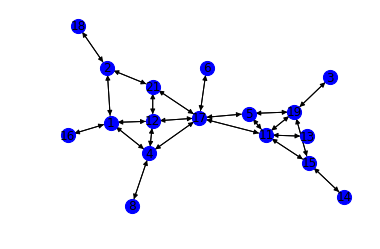

In [83]:
nx.draw_networkx(netfa,node_size=200, node_color='blue')
plt.axis('off') # We don't need axis
plt.show()

**Are managers from the same 1. department, or on the same 2. hirarchy, 3. age, or 4. tenuere more likely to become friends or give advice? ("Become friends", a bit loosely defined here. For the purpose of this assignment, 'Becomming friends' is definead as having a bidirectional friendship edge.)**

In [84]:
# We punch in a bunch af assortativity calculations
Group = pd.DataFrame(columns=list(['Group','Advice','Friends']))
Group.Group = ['Department','Hierarchy', 'Age','Tenure']
Group.Advice = [nx.numeric_assortativity_coefficient(neta, 'DEPT'), nx.numeric_assortativity_coefficient(neta, 'LEVEL'), nx.numeric_assortativity_coefficient(neta, 'AGE'), nx.numeric_assortativity_coefficient(neta, 'TENURE')]
Group.Friends = [nx.numeric_assortativity_coefficient(netfa, 'DEPT'), nx.numeric_assortativity_coefficient(netfa, 'LEVEL'), nx.numeric_assortativity_coefficient(netfa, 'AGE'), nx.numeric_assortativity_coefficient(netfa, 'TENURE')]
Group.set_index('Group', inplace=True)
Group.head()

,Advice,Friends
Group,,
Department,0.107587,0.142082
Hierarchy,0.055397,0.394737
Age,0.038760,-0.038750
Tenure,0.154352,-0.317526


There is a positive correlation (of varying size) betwene groups and advice. 

There is a mixed correlation between groups and being friends, with people in the same department being the most positive and people on tenure being the most negative. The reader is advised that this may occur if any department only have a single person on tenure, or similar structual influences

**Are friends more likely to give each other advice?**

Lets do some math to figure out the likelyhood that you seek advice from a person with whom you have a bidirectional friendship

In [85]:
a = len(nx.get_edge_attributes(netfa, 'bi'))
b = len(nx.get_edge_attributes(netfa, 'a'))
c = b/a
d = nx.density(neta)
print(' The chance of having an advice relation with a friend is: {}'.format(c), '\n' ,'The average chance of having an advice relation: {}'.format(d))

 The chance of having an advice relation with a friend is: 0.5869565217391305 
 The average chance of having an advice relation: 0.4523809523809524


People are more likely to seek advice from people with whom they have a bidirectional friendship!

## **Opgave 3**: Aggregation

**Reconstruct the advice and friendship network on the aggregated level of departments, where nodes represent departments and edges the number of cross departmental friendships/advice relationships.**

Data is split into segments by gdepartment and looped t ocreate graphs

In [0]:
segments = []
for x in sorted(df.DEPT.unique()):
  segments.append(list(df[df.DEPT == x].index))
tags = ['f', 'a']

Graphs = []
for x in tags:
  netx = net.edge_subgraph([(u,v) for u,v,d in net.edges(data=True) if x in d.keys()])
  netag = nx.quotient_graph(netx, segments, relabel = True)
  Graphs.append(netag)

#print(pd.DataFrame(list(netag.edges(data=True))))

**First we do the friendship plot**

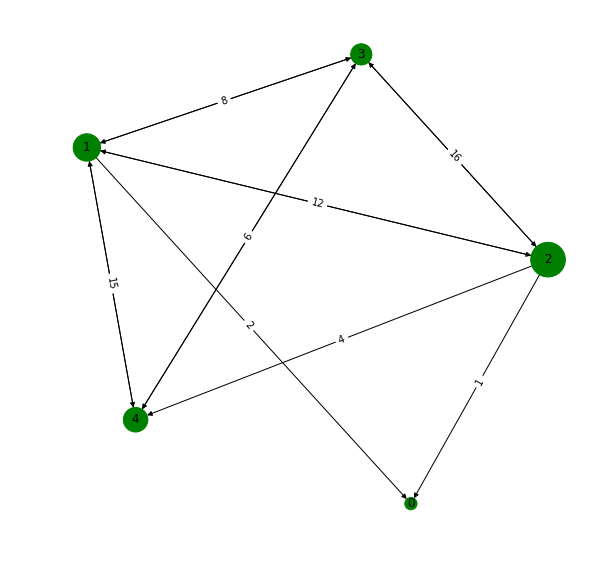

In [90]:
node_size = [Graphs[0].nodes[x]['nnodes'] * 150 for x in Graphs[0].nodes()]
plt.figure(figsize=(10, 10))
pos=nx.spring_layout(Graphs[0], k=70)
nx.draw_networkx(Graphs[0],pos,node_size=node_size, node_color='green', with_labels=True)
labels = nx.get_edge_attributes(Graphs[0],'weight') # I want to se weight of edges as number
nx.draw_networkx_edge_labels(Graphs[0],pos,edge_labels=labels)
plt.axis('off')
plt.show()

Friendship plot complete! The number on the blue nodes show department.

**Now for advice plot**

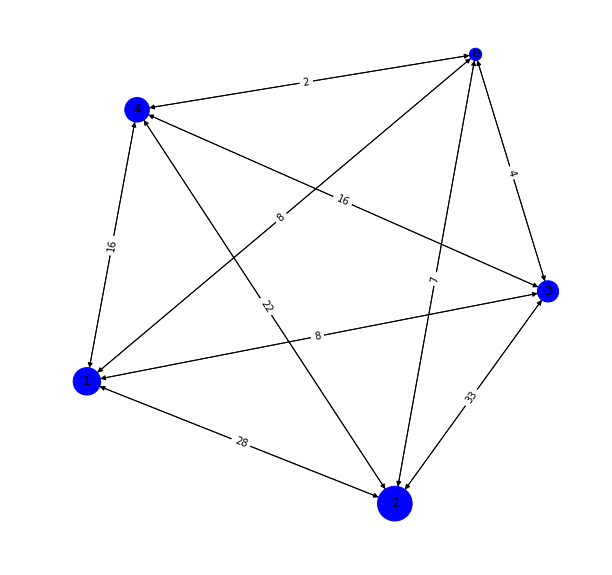

In [88]:
# plotting graph
node_size = [Graphs[1].nodes[x]['nnodes'] * 150 for x in Graphs[1].nodes()]
plt.figure(figsize=(10, 10))
pos=nx.spring_layout(Graphs[1], k=70)
nx.draw_networkx(Graphs[1],pos,node_size=node_size, node_color='blue', with_labels=True)
labels = nx.get_edge_attributes(Graphs[1],'weight')
nx.draw_networkx_edge_labels(Graphs[1],pos,edge_labels=labels) # Setting labels of edges using our variable
plt.axis('off')
plt.show()

Advise plot complete. As above, the number on the nodes represent department number.

## **Opgave 4**

**Everything goes. Show us some pretty and informative plots. Choose what to plot, and how, on your own. Interpret the results and share some insights.**

First a circular plot of directional friendships

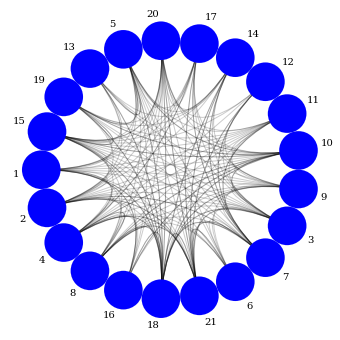

In [105]:
cirkel = nv.CircosPlot(neta, node_labels=True)
cirkel.draw()
plt.axis('off')
plt.show()

Then a circular plot of bidirectional friendships

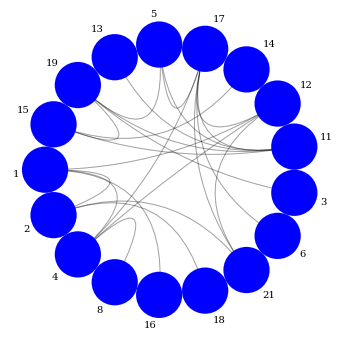

In [106]:
cirkel = nv.CircosPlot(netfa, node_labels=True)
cirkel.draw()
plt.axis('off')
plt.show()

From the two plots we see that there are far fewer connections of bidirectional friends, then one directional friends. So much for workspace community.

Further more, the very popular ID# 2, who were the most popular frind and most sought after advice, have 'only' three bidirectional friendships, whereas several other nodes, among them #11, #4, #17 and #1, have more 'true' freinds.

In [107]:
!jupyter nbconvert --to html m21.ipynb

[NbConvertApp] WARNING | pattern u'm21.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run nbconvert